# TP 7-8 : implémentation de la coloration de graphes

Dans ce TP, l'objectif est d'implémenter la coloration de graphes, en utilisant l'algorithme de Welsh et Powell, dans des graphes non-orientés. 

La représentation choisie pour les graphes est une matrice d'adjacence, qui sera représentée par un tableau de tableau (les noms des sommets sont des entiers et seront numérotés en commençant à 0). Nous considérons que le nombre de sommets du graphe ne pourra pas être modifié une fois le graphe construit.

### Import des modules utiles

In [88]:
%pip install numpy
import numpy as np
from copy import deepcopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Définition des fonctions pour la visualisation des graphes (cellules de code données --> rien à compléter)

### Installation de graphviz pour pouvoir visualiser les graphes

In [89]:
%pip install graphviz
import graphviz
graphviz.__version__, graphviz.version()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


('0.20.1', (9, 0, 0))

### Création d'une fonction de conversion d'un graphe, défini par une matrice d'adjacence, vers le format graphviz

In [90]:
def creation_graphe_graphviz(g):
    # création d'un graphe orienté
    dot = graphviz.Graph()
    
    # ajout des sommets
    for i in range(len(g)):
        dot.node(str(i))
    
    # ajout des arcs
    for i in range(len(g)):
        for j in range(i):
            if g[i][j] == 1:
                dot.edge(str(i), str(j))
    
    return dot

### Création non-orientés, pour tester les fonctions

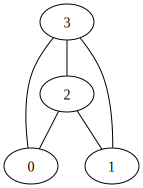

In [91]:
graphe1 = np.array([[0,0,1,1],
                    [0,0,1,1],
                    [1,1,0,1],
                    [1,1,1,0]])
gdot1 = creation_graphe_graphviz(graphe1)
gdot1

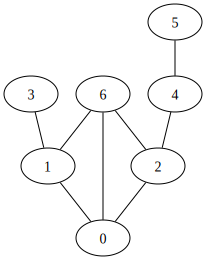

In [92]:
graphe2 = np.array([[0,1,1,0,0,0,1],
                    [1,0,0,1,0,0,1],
                    [1,0,0,0,1,0,1],
                    [0,1,0,0,0,0,0],
                    [0,0,1,0,0,1,0],
                    [0,0,0,0,1,0,0],
                    [1,1,1,0,0,0,0]])
gdot2 = creation_graphe_graphviz(graphe2)
gdot2

## Définition des fonctions utiles pour manipuler les graphes (fonctions données)

#### Fonction qui construit un graphe vide (sans arcs), avec le nombre de sommets donné, et qui retourne la matrice d'adjacence correspondante

In [93]:
def graphe_vide(n):
    return np.zeros((n, n))

#### Fonction qui retourne vrai si l'arete, dont les numéros de sommets extrémités sont donnés, existe

In [94]:
def est_arete(g, i, j):
    return g[i][j] == 1

#### Fonction qui retourne le nombre de sommets du graphe

In [95]:
def nb_sommets(g):
    return len(g)

#### Fonction qui retourne le degré du sommet donné

In [96]:
def degre(g, s):
    return sum(g[:,s])

#### Fonction qui retourne les degrés des sommets du graphe, sous la forme d'un tableau

In [97]:
def degres_sommets(g):
    return [degre(g,i) for i in range(nb_sommets(g))]

## Définition des fonctions à écrire

#### `tri_sommets(graphe)` : trie les sommets de `graphe` selon leur degré décroissant et retourne la liste des sommets ainsi triée

In [98]:
def tri_sommets(graphe):
    sommets_tries = list(range(len(graphe)))  # Initialise avec tous les indices des sommets
    degres = degres_sommets(graphe)  # Récupère les degrés des sommets
    n = len(graphe)
    for _ in range(n):
        for j in range(0, n-1):
            if degres[j] < degres[j+1]:
                # Échange les sommets et leurs degrés
                sommets_tries[j], sommets_tries[j+1] = sommets_tries[j+1], sommets_tries[j]
                degres[j], degres[j+1] = degres[j+1], degres[j]
    return sommets_tries

In [99]:
## test de la fonction tri_sommets
print("tri des sommets du graphe 1, selon leur degré décroissant")
print(tri_sommets(graphe1)) ##[2, 3, 0, 1]

print("\ntri des sommets du graphe 2, selon leur degré décroissant")
print(tri_sommets(graphe2)) ##[0, 1, 2, 6, 4, 3, 5]

tri des sommets du graphe 1, selon leur degré décroissant
[2, 3, 0, 1]

tri des sommets du graphe 2, selon leur degré décroissant
[0, 1, 2, 6, 4, 3, 5]


#### `couleur_courante_possible(graphe, sommet_cour, sommets_couleur_cour)` : retourne vrai si le sommet `sommet_cour` peut être colorié de la couleur courante, représentée par les sommets `sommets_couleur_cour` qui sont déjà coloriés de cette couleur, et faux sinon. 
`sommet_cour` peut être colorié par la couleur courante s'il n'a pas d'arête commune avec les sommets de la liste `sommets_couleur_cour`, dans le graphe `graphe`.

In [100]:
def couleur_courante_possible(graphe, sommet_cour, sommets_couleur_cour):
    for i in sommets_couleur_cour :
        if est_arete(graphe, sommet_cour, i) :
            return False
    return True

In [101]:
## test de la fonction couleur_courante_possible
print("coloration possible pour le sommet 0, pour graphe1 ?")
print(couleur_courante_possible(graphe1, 0, [1])) ##True

print("coloration possible pour le sommet 0, pour graphe1 ?")
print(couleur_courante_possible(graphe1, 0, [1, 2])) ##False

print("coloration possible pour le sommet 0, pour graphe2 ?")
print(couleur_courante_possible(graphe2, 0, [3, 6])) ##False

print("coloration possible pour le sommet 0, pour graphe2 ?")
print(couleur_courante_possible(graphe2, 0, [3, 4])) ##True

coloration possible pour le sommet 0, pour graphe1 ?
True
coloration possible pour le sommet 0, pour graphe1 ?
False
coloration possible pour le sommet 0, pour graphe2 ?
False
coloration possible pour le sommet 0, pour graphe2 ?
True


#### `coloration_sommets_welsh_powell(graphe)` : fait la coloration des sommets de `graphe`, avec l'algorithme de Welsh-Powell, et retourne un dictionnaire
Le dictionnaire, retourné par la fonction, associe chaque sommet (clé du dictionnaire, de type entier) avec sa couleur (valeur du dictionnaire, de type entier).

In [102]:
def coloration_sommets_welsh_powell(graphe):
    # initialisation du dictionnaire (pas de couleur au départ pour les sommets)
    couleurs = {k: None for k in range(nb_sommets(graphe))}
       
    # à compléter
    ordre = tri_sommets(graphe)
    liCol = [[]]
    for i in ordre :
        colorFound = False
        for j in range(len(liCol)-1) :
            if couleur_courante_possible(graphe, i, liCol[j]) and not colorFound :
                couleurs[i] = j
                liCol[j].append(i)
                colorFound = True
        if not colorFound :
            liCol.append([i])
            couleurs[i] = len(liCol)-1
    
    return couleurs

In [103]:
## test de la fonction coloration_sommets_welsh_powell
print("coloration des sommets du graphe 1")
couleurs_sommets1 = coloration_sommets_welsh_powell(graphe1)
print(couleurs_sommets1)

print("\ncoloration des sommets du graphe 2")
couleurs_sommets2 = coloration_sommets_welsh_powell(graphe2)
print(couleurs_sommets2)

coloration des sommets du graphe 1
{0: 2, 1: 3, 2: 1, 3: 0}

coloration des sommets du graphe 2
{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 2}


#### `affichage_couleurs_sommets_graphviz(graphe, coloration)` : affiche la coloration des sommets d'un graphe
Reprenez la fonction `creation_graphe_graphviz(g)` et regardez le projet graphviz pour Python (https://graphviz.readthedocs.io/en/stable/examples.html?highlight=color#) pour afficher les couleurs des sommets sur le graphe (vous pouvez également regarder la page https://graphviz.org/doc/info/colors.html, pour avoir les noms de couleurs utilisables). 
Le graphe avec les sommets coloriés est obtenu à partir de `graphe`, le graphe de départ, et de `coloration`, le dictionnaire contenant la coloration des sommets (obtenu en résultat de la fonction `coloration_sommets_welsh_powell(graphe)`).

In [112]:
def affichage_couleurs_sommets_graphviz(graphe, coloration):
    # création d'un graphe non orienté, avec des sommets coloriés
    dot_col_som = graphviz.Graph()
    
    colorList = {
        0 : '#0000ff42',
        1 : '#00ff0042',
        2 : '#00ffff42',
        3 : '#ff000042',
        4 : '#ff00ff42',
        5 : '#ffff0042',
        6 : '#0000aa42',
        7 : '#00aa0042',
        8 : '#00aaaa42',
        9 : '#aa000042',
    }
    
    # ajout des sommets
    # for i in range(len(graphe)):
    #     dot_col_som.node(str(i), fillcolor = colorList[coloration[i]])
    for sommet, couleur in coloration.items():
        # print(sommet, couleur, colorList[couleur])
        dot_col_som.node(str(sommet), style='filled', fillcolor=colorList[couleur])
    
    # ajout des arcs
    for i in range(len(graphe)):
        for j in range(i):
            if graphe[i][j] == 1:
                dot_col_som.edge(str(i), str(j))
    
    return dot_col_som

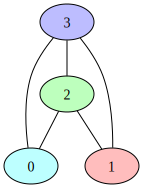

In [114]:
## test de la fonction affichage_couleurs_sommets_graphviz
res = affichage_couleurs_sommets_graphviz(graphe1, coloration_sommets_welsh_powell(graphe1))
res

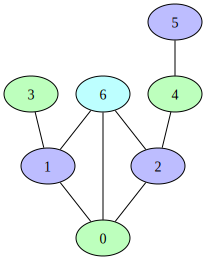

In [115]:
## test de la fonction affichage_couleurs_sommets_graphviz
res = affichage_couleurs_sommets_graphviz(graphe2, coloration_sommets_welsh_powell(graphe2))
res

## Implémentation des fonctions bonus (cellules de code à compléter)

#### `graphe_aux_aretes(graphe)` : construit le graphe aux arêtes correspondant à `graphe`
Les noms des sommets, dans le graphe aux arêtes, sont des tuples contenant les 2 numéros de sommets composant l'arête. La fonction retourne à la fois la matrice correspondant au graphe aux arêtes (variable `g_aretes`) et le dictionnaire donnant la correspondance entre chaque numéro de sommet dans le graphe aux arêtes et le nom de l'arête qu'il représente (variable `dict_aretes`).

In [29]:
def graphe_aux_aretes(graphe):
    g_aretes = graphe_vide(nb_aretes(graphe))
    dict_aretes = {}
    
    # à compléter
    
    return (g_aretes, dict_aretes)

In [30]:
## test de la fonction graphe_aux_aretes

#### `coloration_aretes_welsh_powell(graphe)` : fait la coloration d'arêtes, de `graphe`, avec l'algorithme de Welsh-Powell

Le dictionnaire, retourné par la fonction, associe chaque arête (clé du dictionnaire, de type entier) avec sa couleur (valeur du dictionnaire, de type entier). Une arête est définie par un tuple contenant les 2 numéros de sommets composant l'arête.

In [31]:
def coloration_aretes_welsh_powell(graphe):
    couleurs = {}
    
    # à compléter
    
    return couleurs

In [32]:
## test de la fonction coloration_aretes_welsh_powell

#### `affichage_couleurs_aretes_graphviz(graphe, coloration)`: affiche la coloration des arêtes d'un graphe
Reprenez la fonction `creation_graphe_graphviz(g)` et regardez le projet graphviz pour Python (https://pypi.org/project/graphviz/) pour afficher les couleurs des arêtes sur le graphe (vous pouvez également regarder la page https://graphviz.org/doc/info/colors.html, pour avoir les noms de couleurs utilisables). 
Le graphe avec les arêtes coloriées est obtenu à partir de `graphe`, le graphe de départ, et de `coloration`, la coloration des arêtes donnée sous la forme d'un dictionnaire (obtenu en résultat de la fonction `coloration_aretes_welsh_powell(graphe)`).

In [ ]:
def affichage_couleurs_aretes_graphviz(graphe, coloration):
    # création d'un graphe non orienté, avec des arêtes coloriés
    dot_col_aretes = graphviz.Graph()
    
    # compléter
    
    return dot_col_aretes

In [ ]:
# test de la fonction affichage_couleurs_aretes_graphviz